<a href="https://colab.research.google.com/github/JamesPeralta/NeuroNexus2019/blob/master/ModelTraining/Iteration3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive and download libraries from Github

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Any imports

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import cv2 
from sklearn.feature_extraction import image
import math
from keras.utils import np_utils
import keras
from sklearn.utils import shuffle
from skimage import io, color, img_as_float

### Retrieve slices and thier ground-truth

In [3]:
# CD into the data
# CD into the data
t1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/HC_T1.nii'
c1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c1HC_T1.nii'

t1_nii = nib.load(t1)
t1_np = np.array(t1_nii.dataobj)
print(t1_np.shape)

c1_nii = nib.load(c1)
c1_np = np.array(c1_nii.dataobj)
print(c1_np.shape)

(256, 256, 344)
(256, 256, 344)


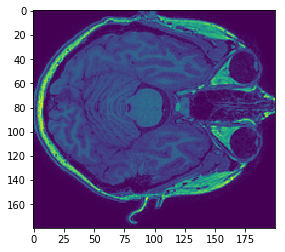

In [243]:
plt.imshow(t1_np[50:230, 30:230, 108])

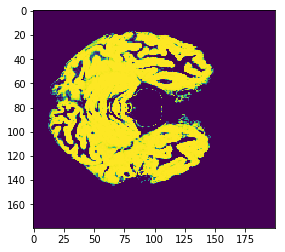

In [244]:
plt.imshow(c1_np[50:230, 30:230, 108])

In [0]:
print(c1_np[50:230, 30:230, 108].shape)
print(t1_np[50:230, 30:230, 108].shape)

### Extract patches

In [320]:
t1_patches = shuffle(image.extract_patches_2d(t1_np[50:230, 30:230, 108], (33, 33)) / 1390, random_state=0)
c1_patches = shuffle(image.extract_patches_2d(c1_np[50:230, 30:230, 108], (33, 33)), random_state=0)

print(t1_patches.shape)
print(c1_patches.shape)

(24864, 33, 33)
(24864, 33, 33)


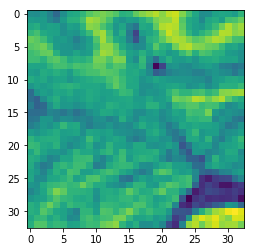

In [330]:
plt.imshow(t1_patches[2000])

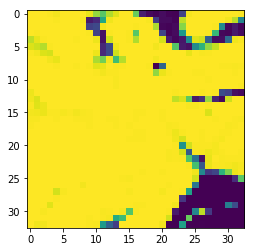

In [331]:
plt.imshow(c1_patches[2000])

In [332]:
x = t1_patches.reshape((24864, 33, 33, 1))
print(x.shape)

(24864, 33, 33, 1)


In [335]:
# Convert c1 patch to thier labels
y = label_patches(c1_patches)
y.shape

(24864, 2)

In [341]:
print(y)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## Creating the Neural Network

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [0]:
# Define the models architecture
def create_model():
    # Build the architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=(33, 33, 1), padding="same"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.01), metrics=['acc'])
  
    return model

In [345]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 33, 33, 32)        320       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                262176    
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 66        
Total params: 262,562
Trainable params: 262,562
Non-trainable params: 0
_________________________________________________________________


In [346]:
model.fit(x, y, batch_size=128, epochs=50, shuffle=True)

Epoch 1/50
24864/24864 [==============================] - 1s 59us/sample - loss: 0.3072 - acc: 0.8785
Epoch 2/50
24864/24864 [==============================] - 1s 40us/sample - loss: 0.1538 - acc: 0.9438
Epoch 3/50
24864/24864 [==============================] - 1s 39us/sample - loss: 0.1159 - acc: 0.9564
Epoch 4/50
24864/24864 [==============================] - 1s 40us/sample - loss: 0.0993 - acc: 0.9625
Epoch 5/50
24864/24864 [==============================] - 1s 39us/sample - loss: 0.0896 - acc: 0.9650
Epoch 6/50
24864/24864 [==============================] - 1s 39us/sample - loss: 0.0823 - acc: 0.9689
Epoch 7/50
24864/24864 [==============================] - 1s 39us/sample - loss: 0.0744 - acc: 0.9714
Epoch 8/50
24864/24864 [==============================] - 1s 41us/sample - loss: 0.0715 - acc: 0.9720
Epoch 9/50
24864/24864 [==============================] - 1s 39us/sample - loss: 0.0650 - acc: 0.9748
Epoch 10/50
24864/24864 [==============================] - 1s 39us/sample - loss: 

## Predict Batch and re-construct the image

In [0]:
test_patches = image.extract_patches_2d(t1_np[50:230, 30:230, 108], (33, 33)) / 1390
test_patches = test_patches.reshape((24864, 33, 33, 1))

In [0]:
this = np.array(model.predict_classes(test_patches)).astype(np.float)

In [365]:
print(this.shape)

(24864,)


In [0]:
plt.imshow(c1_patches[0].reshape(33,33))

In [0]:
done = this.reshape((148, 168))

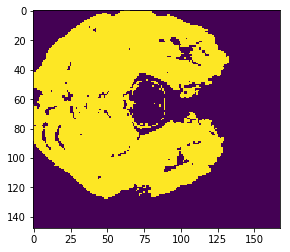

In [367]:
plt.imshow(done)

---
# Helpers

In [0]:
one_index = []
def label_patches(patches):
    '''
    Always pass in square patches with an odd width and height
    This is needed for use to calculate the center pixel

    :param patches: Patches you would like to label
    :return:
    '''
    labels_list = []
    dim = math.ceil(len(patches[0, 1, :]) / 2)

    for index, patch in enumerate(patches):
        if patch[dim, dim] > 0.95:
            labels_list.append("1")
            one_index.append(index)
        else:
            labels_list.append("0")
          
    return keras.utils.to_categorical(labels_list, num_classes=2)

In [336]:
len(one_index)

11334